In [1]:
using Distributions, LinearAlgebra
using JuMP, GLPK
using Plots, StatsPlots

In [2]:
gr(size=(500,500), html_output_format=:png)

Plots.GRBackend()

The basic idea here is that we modify ELP.P so that it observes a set of graphs $\mathcal{G}_t = (G_{1,t}, G_{2,t}, ... G_{C,t})$ at time $t$. The probability $p_{g, i, t}^{(meta)}$ of the observed feedback being drawn from graph $g$ is some categorical distribution for each action $i$. We will assume the distribution is fixed but ideally would like to allow adversarial ordering (analogous to the standard adversarial bandit setting). If we were informed of these probabilities at the beginning of a round, then I believe we can simply modify the ELP.P linear program to maximize the minimum of the weighted sum of the probabilities of observing each vertex. 

If we are not informed of these probabilities, as in our setting, things are more complicated. In the optimal tax setting the probabilities are dependent on the reward, but again we can preserve the generality by not requiring that (and I think this probably does not lose us too much if any efficiency).

So we observe a set of graphs, take an action, and then the losses and the selected graph are observed. Importantly we do not learn which graph would have been selected for all vertives. In the optimal tax setting there is in fact a kind of recursive problem where we learn which graph would have been selected for all vertices where we observe losses, that is all vertices in the neighborhood of the selected vertex for the graph that was chosen. 

In our case the "meta" feedback system that indicates when we learn which graph would have been associated with each vertex is identical to the feedback system for the losses, but in full generality this need not be the case. I think there's probably an optimal way to estimate the probabilites without infinite recursion but I am not sure what it would be. To me its tempting to try to run a modified version of EXP3-SET to estimate the probabilites, and then run ELP.P with a couple minor modifications. 

Different from all settings in the original paper we do not observe the information required to estimate $q_{it}$ in full. In round $t$ we play an action and learn the graph $g_{I_t}$ that determines the feedback for the losses, and for some subset $S_t$ of vertices we observe which graph would have been the feedback system had that vertext been selected. This means we do not observe enough information to calculate $q_{it}$. We can instead estimate 

\begin{align}
\hat q_{it} &= q_{it}^{(obs)} + q_{it}^{(est)}\\
q_{it}^{(obs)} &= \sum_{j \in G_{g_{I_t}, t} | j \rightarrow i} p_{j, t}\\
q_{it}^{(est)} &= \sum_{g = 1}^C \sum_{j \in G_{g, t} | j \rightarrow i} p_{g, i, t}^{(meta)} p_{j, t}
\end{align}

Using this estimator for $q_{it}$ I think we can run the modified ELP.P as above using the estimated probabilities p_{g,i,t} as though they were given, and updating these probabilities according to the Exp3-Set update rule with the cross entropy loss.

In [3]:
function elpp2(K, T, G, R, delta, eta, eta_meta)
    w = ones(K, T + 1)
    w_meta = ones(2, K, T + 1)
    beta = 2 * eta * sqrt(log(5 * K / delta) / log(K))
    for t in 1:T
        G_t = G(t)
        p_t_meta = w_meta[:, :, t] ./ sum(w_meta[:, :, t], dims=1)
        model = Model(GLPK.Optimizer)
        @variable(model, s[1:K])
        @variable(model, min_s)
        @constraint(model, c1, sum(s) == 1)
        @constraint(model, c2, s .>= 0)
        @constraint(model, c3, p_t_meta[1, :] .* (G_t[1] * s) + \
                               p_t_meta[2, :] .* (G_t[2] * s)   \
                               .>= min_s)
        @objective(model, Max, min_s)
        optimize!(model)
        nu_t = (1 + beta) * eta / value(min_s)
        p_t = (1 - nu_t) * w[:, t] / sum(w[:, t]) + nu_t * value.(s)
        a_t = rand(Categorical(p_t))
        R_t, g_t = R(t)
        q_t = G_t[g_t] * p_t
        hat_R_t = (G_t[g_t][:, a_t] .* R_t .+ beta) ./ q_t
        w[:, t+1] = w[:, t] .* exp.(eta * hat_R_t)
    end
    return w
end    

elpp (generic function with 1 method)

In [4]:
K = 100
G_1 = UpperTriangular(ones(K, K))
G_0 = UpperTriangular(ones(K, K))'

gen_G(t, a_t) = G_1, G_0

gen_G (generic function with 1 method)

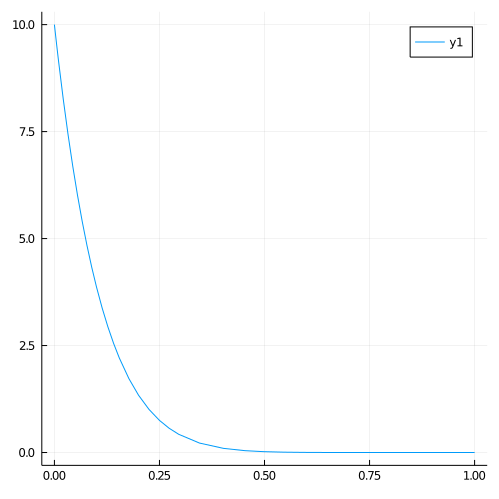

In [5]:
d = Beta(1, 10);
plot(d)

In [20]:
arm_levels = cumsum(ones(K) / (K + 1))
floor = 1
arm_rewards = (floor .+ (1 - floor) * arm_levels)
function gen_R(t, a_t) 
    # for now only 2 graphs, one condition
    R = arm_rewards .* (arm_levels .< rand(d))
    return R, Int(R[a_t] == 0)
end

gen_R (generic function with 1 method)

In [21]:
eta = 1 / (3 * K) 
delta = 0.1
T = 10000
w = elpp(K, T, gen_G, gen_R, delta, eta)
print(sortperm(w[:, T + 1]))

LoadError: MethodError: no method matching gen_G(::Int64)
Closest candidates are:
  gen_G(::Any, !Matched::Any) at In[4]:5

In [22]:
gen_R(0, 90)

([1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 1)

In [23]:
w_c = ones(2, K, T + 1)

2×100×10001 Array{Float64,3}:
[:, :, 1] =
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0

[:, :, 2] =
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0

[:, :, 3] =
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0

...

[:, :, 9999] =
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0

[:, :, 10000] =
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0

[:, :, 10001] =
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0

In [36]:
p_c_t = w_c[:, :, 1] ./ sum(w_c[:, :, 1], dims=1)

2×100 Array{Float64,2}:
 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  …  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5     0.5  0.5  0.5  0.5  0.5  0.5  0.5

In [35]:
sum(w_c[:, :, 1], dims=1)

1×100 Array{Float64,2}:
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  …  2.0  2.0  2.0  2.0  2.0  2.0  2.0